# Code to visualize GPT2 attention weights pre- and post-finetuning with Seinfeld scripts.  Particially adpated and modified from https://github.com/text-machine-lab/dark-secrets-of-BERT/blob/master/visualize_attention.ipynb

# This notebook is based on the huggingface transformers repo (https://github.com/huggingface/transformers) and utilize many functionalities from that repo
## For fine-tuning GPT2, see previous blog post [GPT2 writes Seinfeld]()

In [1]:
# Install additional packages if haven't already done so
# !pip install matplotlib nltk spacy textacy
# !python -m spacy download en_core_web_sm 

In [2]:
import itertools
import random

import matplotlib.pyplot as plt
import nltk
import numpy as np
import spacy
import textacy
import torch
from matplotlib.gridspec import GridSpec
from nltk import word_tokenize
from nltk.corpus import framenet as fn
from nltk.tokenize import word_tokenize
from spacy.symbols import nsubj, VERB
from tqdm import tqdm

from transformers import (
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer
)
nlp = spacy.load("en_core_web_sm")
%matplotlib inline
plt.style.use('seaborn')

## Functions used

In [6]:
def visualize_single(att_map, tokens, n_layer, n_head):
    """
    Attention map for a given layer and head
    """
    plt.figure(figsize=(16, 12))
    crop_len = len(tokens)
    plt.imshow(att_map[n_layer, n_head, :crop_len, :crop_len], cmap='Reds')
    plt.xticks(range(crop_len), tokens, rotation=60, fontsize=12)
    plt.yticks(range(crop_len), tokens, fontsize=12)

    plt.grid(False)


In [7]:
def visualize_all(attn, crop_len, n_layers=12, n_heads=12, title=""):
    """
    Full grid of attention maps [12x12]
    """
    fig, axes = plt.subplots(n_layers, n_heads, figsize=(15, 12), sharex=True, sharey=True)
    
    for i in range(n_layers):
        for j in range(n_heads):
            im = axes[i, j].imshow(attn[i, j, :crop_len, :crop_len], cmap='Oranges')
            axes[i, j].axis('off')
    fig.colorbar(im, ax=axes.ravel().tolist())
    fig.suptitle(title, fontsize=20)


In [8]:
def visualize_before_and_after(before, after, title='', cmap="Greens"):
    """
    Visualize the difference between base BERT and fine-tuned BERT
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    ax1, ax2 = axes[0], axes[1]

    vmax = max(np.max(before), np.max(after))

    im = ax1.imshow(before, cmap=cmap, vmax=vmax)
    ax1.set_title('Base model')
    ax1.grid(False)

    im = ax2.imshow(after, cmap=cmap, vmax=vmax)
    ax2.set_title('Fine-tuned model')
    ax2.grid(False)

    fig.colorbar(im, ax=axes.ravel().tolist())
    fig.suptitle(title, fontsize=20)


In [9]:
# See spacy docs for tag-pos relation
def detect_all_pos(sentence, pos='PRON'):
    """
    Detect all tokens with a given POS tag
    """
    if pos not in ['PRON', 'VERB', 'NOUN']:
        raise ValueError("POS not recognized")
        
    pos2tag = {'PRON': ['PRP', 'PRP$'],
               'NOUN': ['NN', 'NNP', 'NNPS', 'NNS'],
               'VERB': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']}
    
    doc = nlp(sentence, disable=['ner', 'parser'])
    targets = []
    for token in doc:
        if token.tag_ in pos2tag[pos]:
            targets.append(token.text)
    return set(targets)

In [10]:
def detect_all_negations(sentence):
    """
    Check if there is a negation phrase in a sentence out of a list of manually curated negations
    """
    negation_words = ['neither', 'nor', 'not', 'never', 'none', "don't", "won't", "didn't", 
                     "hadn't", "haven't", "can't", "isn't", "wasn't", "shouldn't", "couldn't", "nothing", "nowhere"]
    
    targets = [word for word in negation_words if word in sentence]
    return set(targets)

In [11]:
def detect_all_dep(sentence, label):
    """
    Get subject-object dependencies
    """
    doc = nlp(sentence, disable=['ner', 'pos'])
    
    label2dep = {'SUBJ': ['nsubj', "nsubjpass", "csubj", "csubjpass", "agent", "expl"], 
                 "OBJ": ['dobj', 'iobj', "dative", "attr", "oprd"]}
    
    targets = []
    for token in doc:
        if token.dep_ in label2dep[label]:
            targets.append(token.text)
    return set(targets)

In [12]:
def get_max_target_weight(attn, target_indices):
    """
    Get the maximum attn weight out of target tokens (given by their indices)
    """
    if not target_indices:
        return 0
    avg_attn = np.mean(attn, axis=0)
    target_weights = avg_attn[target_indices]
    max_target_weight = np.max(target_weights)
    return max_target_weight

In [13]:
def encode_input_text(text, tokenizer):
    tokenized_text = tokenizer.tokenize(text)
    ids = torch.LongTensor(tokenizer.convert_tokens_to_ids(tokenized_text))
    return tokenizer.build_inputs_with_special_tokens(ids)

In [14]:
def analyze_target_attention(sentence, max_len, model, feature='NOUN', n_layers=12, n_heads=12):
    """
    Analyze the attention weights for a sentence and for a given syntactic feature
    """
    weights = np.zeros((n_layers, n_heads))
    tokens = tokenizer.tokenize(sentence)
    if feature in ["NOUN", "PRON", "VERB"]:
        target_feat = detect_all_pos(sentence, feature)
    elif feature == "NEG":
        target_feat = detect_all_negations(sentence)
    elif feature in ["SUBJ", "OBJ"]:
        target_feat = detect_all_dep(sentence, feature)
    tokens_feat = list(itertools.chain.from_iterable([tokenizer.tokenize(feat) for feat in target_feat]))
    feat_indices = [i for i, token in enumerate(tokens) if token in tokens_feat]

    input_ids = encode_input_text(sentence, tokenizer)
    _, _, output = model(input_ids)

    output = torch.stack(output).detach().numpy()

    for l in range(n_layers):
        for h in range(n_heads):
            weights[l, h] = get_max_target_weight(output[l, h, :, :], feat_indices)
    
    return weights
            

In [15]:
def extract_subj_verb(sentence):
    """
    Get subject-verb dependencies
    """
    doc = nlp(sentence)
    
    subj_verb = [] 
    for possible_subject in doc:
        if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
            subj_verb.append((possible_subject.text, possible_subject.head.text))
    return subj_verb

In [19]:
def read_dataset(file_path, tokenizer, block_size):
    """
    Read text file and convert to token ids with tokenizer, truncate into blocks of block_size
    """
    data = []
    with open(file_path, encoding="utf-8") as f:
        text = f.read()
    tokenized_text = tokenizer.tokenize(text)
    # pdb.set_trace()
    ids = torch.LongTensor(tokenizer.convert_tokens_to_ids(tokenized_text))
    for i in range(0, len(ids) - block_size + 1, block_size):  # Truncate in block of block_size
        data.append(tokenizer.build_inputs_with_special_tokens(ids[i : i + block_size]))
    return data

In [20]:
def read_dataset_text(file_path, block_size):
    """
    Read text file and tokenize into words, truncate into blocks of block_size, join together into strings
    """
    data = []
    with open(file_path, encoding="utf-8") as f:
        text = f.read()
    tokens = word_tokenize(text)
    # tokenizer.tokenize(text)
    for i in range(0, len(tokens) - block_size + 1, block_size):  # Truncate in block of block_size
        data.append(' '.join(tokens[i : i + block_size]))
    return data

-------------------------------------

## Setting parameters

In [21]:
max_len = 60
path_to_data = './examples/seinfeld/all_scripts.txt'
task = 'Seinfeld'
# Model property: https://huggingface.co/transformers/v2.2.0/pretrained_models.html
n_layers = 12
n_heads = 12
# path_to_model = '../pretrained_models/v2/{}/fine-tuned/'.format(task.lower())
finetuned_model_path = './examples/output/'
device = 'cpu'

# Workflow:
0. Pick the dataset
1. Load the dataset and the fine-tuned model
2. Plot 12x12 attention map for a random example (before and after fine-tuning)
3. Compute and plot **averaged over data examples** cosine similarity map \[between `baseBERT` and `fine-tunedBERT` \]
4. Analyze attention to target-sentence tokens:
    * NOUNS/VERBS/PRONOUNS
    * OBJECTS/SUBJECTS
5. Analyze cross-attention (source-to-target tokens)
6. Repeat for other datasets as needed
7. Analyze base BERT

--------------------------

### 1.1 Load the tokenizer, base model and fine-tuned model
**Note the `output_attentions` param of the config object is set to `True` for model to output attention_probs**

In [22]:
# Code from examples/run_lm_finetuning.py, how to use pretrained model and tokenizer(this paper used pretrain tokenizer throughout)

config_class = GPT2Config 
model_class = GPT2LMHeadModel 
tokenizer_class = GPT2Tokenizer

config = config_class.from_pretrained('gpt2')
# Change default config to make model output attention probs as well
config.output_attentions = True

tokenizer = tokenizer_class.from_pretrained('gpt2')

model_base = model_class.from_pretrained(
    'gpt2',
    config=config
)
model_base.eval()
model_base.to(device)

# Load up the fine-tuned model trained on seinfeld dataset
finetuned_model_path = './examples/output'
model_finetuned = model_class.from_pretrained(
    finetuned_model_path,
    config=config
)
model_finetuned.eval()
model_finetuned.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

### 1.2 Load dataset as a list of tokenized blocks converted to ids

In [23]:
import pdb
data = read_dataset(path_to_data, tokenizer, max_len)

In [24]:
data[1]

tensor([44713, 25780, 13075,  1001, 47187,   220,  8982, 10009, 44713,   492,
         4502,  6446, 35819,   220, 22300,  5593,    12,    35,  4364,    69,
          385, 20004, 12359, 41463,  3932,   274,   220,  3899, 14743, 20004,
        34617, 41454,   220,   220, 22358, 10271,    25,   220,   220,  3941,
         5256,  5404,   220, 27754, 12359, 15686,   220, 13695,   259,  7459,
          220, 27754,  1106,  6575,   220,  5199,  2094,  1636, 44713,  1106])

In [25]:
## for big datasets
if len(data) > 1000:    
    data = random.sample(data, 1000)

### 2. 12x12 attention map for a random example

In [26]:
test_sent = 'JERRY: Went out to dinner the other night. Check came at the end of the meal, as it always does. Never liked the check at the end of the meal system'

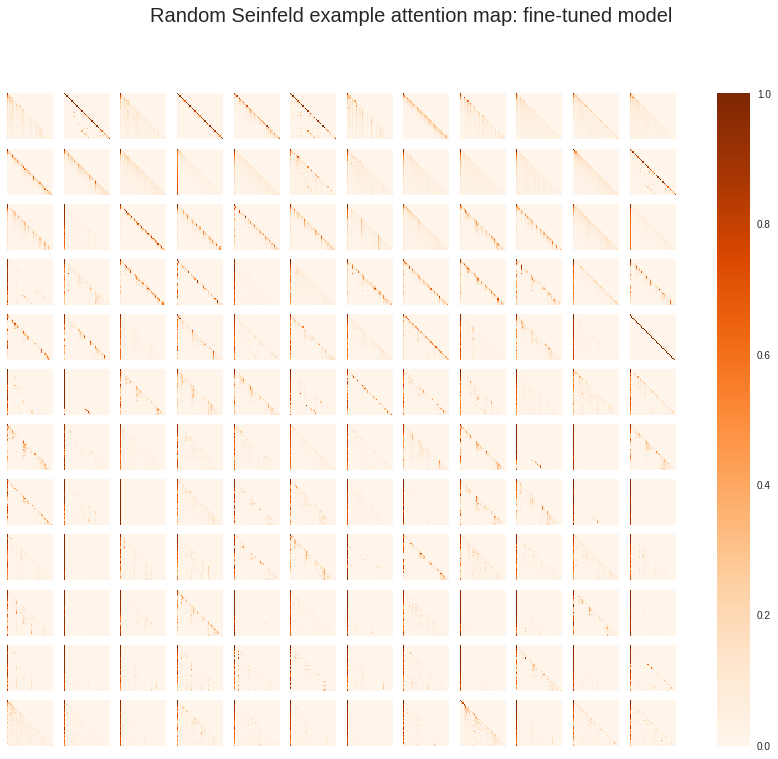

In [27]:
rand_example = encode_input_text(test_sent, tokenizer)
_, _, rand_attn_finetuned = model_finetuned(rand_example)
_, _, rand_attn_base = model_base(rand_example)
rand_attn_finetuned = torch.stack(rand_attn_finetuned).detach().numpy()
rand_attn_base = torch.stack(rand_attn_base).detach().numpy()
crop_len = len(rand_example)
visualize_all(rand_attn_finetuned, crop_len, title="Random {} example attention map: fine-tuned model".format(task))

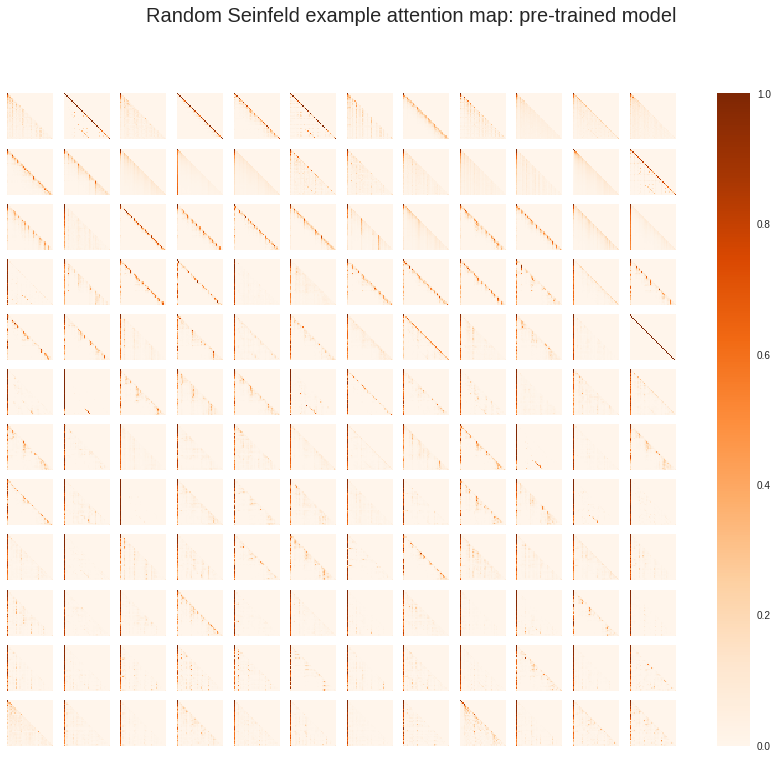

In [28]:
visualize_all(rand_attn_base, crop_len, title="Random {} example attention map: pre-trained model".format(task))

In [29]:
rand_example

tensor([   41,  1137, 18276,    25, 29866,   503,   284,  8073,   262,   584,
         1755,    13,  6822,  1625,   379,   262,   886,   286,   262,  9799,
           11,   355,   340,  1464,   857,    13,  7236,  8288,   262,  2198,
          379,   262,   886,   286,   262,  9799,  1080])

In [30]:
np.sum(np.isclose(rand_attn_base, rand_attn_finetuned))
# About half of fine-tuned weights 'close' to base weights

96837

['J', 'ER', 'RY', ':', 'ĠWent', 'Ġout', 'Ġto', 'Ġdinner', 'Ġthe', 'Ġother', 'Ġnight', '.', 'ĠCheck', 'Ġcame', 'Ġat', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġmeal', ',', 'Ġas', 'Ġit', 'Ġalways', 'Ġdoes', '.', 'ĠNever', 'Ġliked', 'Ġthe', 'Ġcheck', 'Ġat', 'Ġthe', 'Ġend', 'Ġof', 'Ġthe', 'Ġmeal', 'Ġsystem']


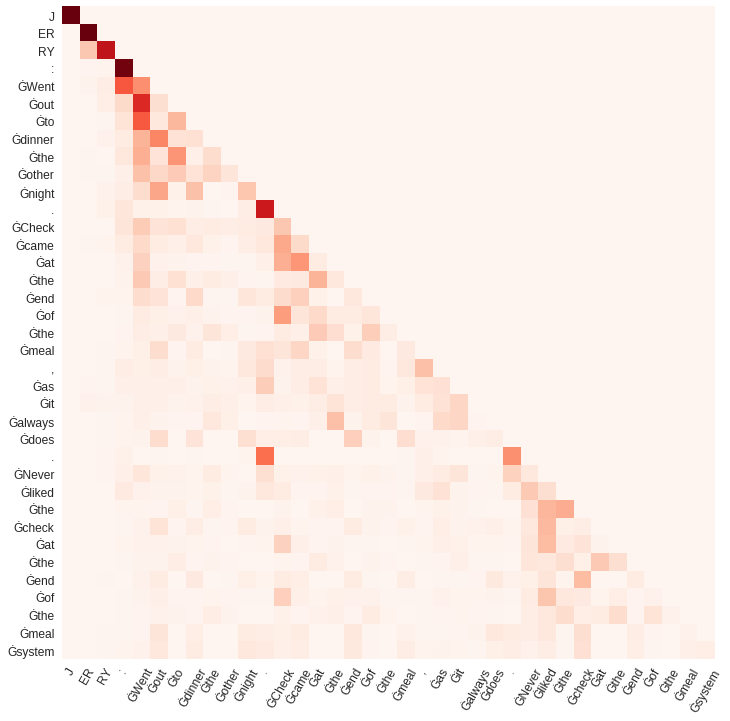

In [31]:
#rand_example = random.choice(data)
tokens = tokenizer.convert_ids_to_tokens(rand_example, skip_special_tokens=False)
print(tokens)
_, _, rand_attn_finetuned = model_finetuned(rand_example)
rand_attn_finetuned = torch.stack(rand_attn_finetuned).detach().numpy()
visualize_single(rand_attn_finetuned, tokens, 11, 8)

### 3. Cosine similarity map 
#### Attention weights after one epoch fine-tuning on Seinfeld scripts appears VERY similar to base model in all layers and all heads

100%|██████████| 1000/1000 [06:05<00:00,  2.74it/s]


Text(0, 0.5, 'Layer id')

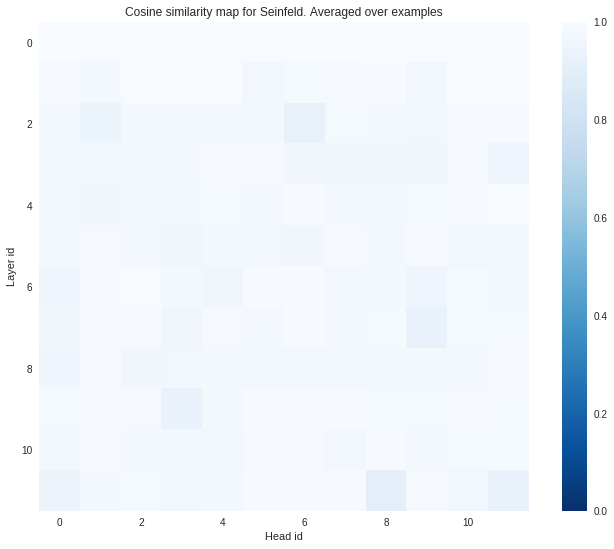

In [32]:
all_similarities = []
for example in tqdm(data):
    _, _, rand_attn_finetuned = model_finetuned(example)
    _, _, rand_attn_base = model_base(example)
    rand_attn_finetuned = torch.stack(rand_attn_finetuned)
    rand_attn_base = torch.stack(rand_attn_base)
    #print(rand_attn_finetuned.shape)   
    finetuned_vec = rand_attn_finetuned.squeeze(0).view(n_layers, n_heads, -1)
    base_vec = rand_attn_base.squeeze(0).view(n_layers, n_heads, -1)

    sim_map = torch.nn.functional.cosine_similarity(base_vec, finetuned_vec, dim=-1).detach().numpy()
    all_similarities.append(sim_map)
all_similarities = np.stack(all_similarities, axis=-1)
avg_sim = np.mean(all_similarities, axis=-1)
plt.figure(figsize=(12, 9))
plt.imshow(avg_sim, cmap='Blues_r', vmin=0, vmax=1)
plt.colorbar()
plt.grid(False)
plt.title('Cosine similarity map for {}. Averaged over examples'.format(task))
plt.xlabel('Head id')
plt.ylabel('Layer id')

### 4. These experiments need a text dataset (with sentences being strings)

In [33]:
text_data = read_dataset_text(path_to_data, max_len)
if len(text_data) > 1000:    
    text_data = random.sample(text_data, 1000)

### 4.1 Target nouns

100%|██████████| 1000/1000 [07:30<00:00,  2.22it/s]


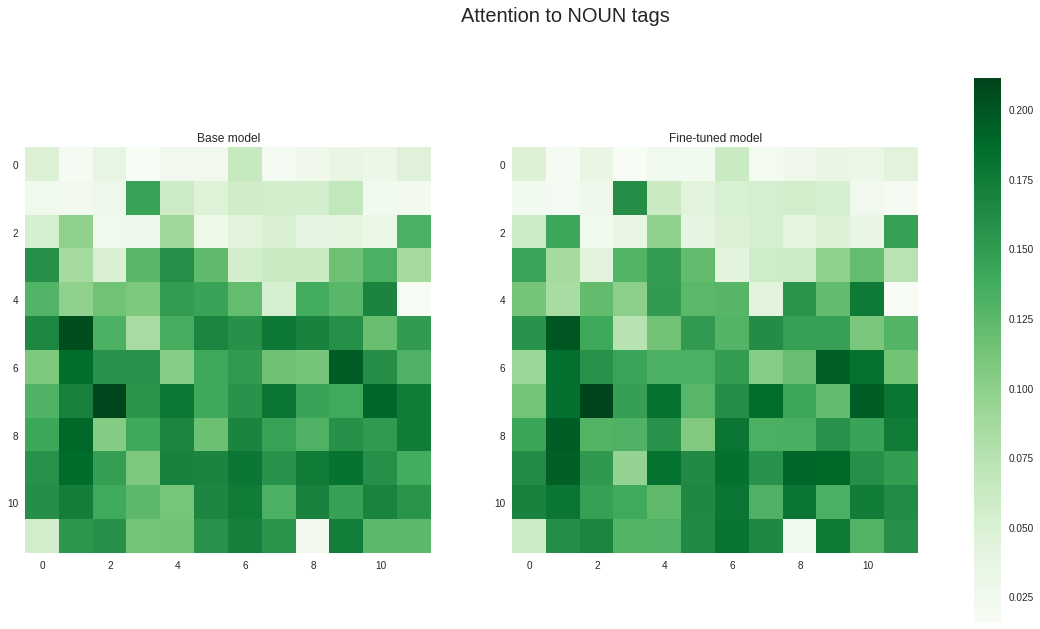

In [35]:
pos = 'NOUN'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(text_data):
    weights_finetuned = analyze_target_attention(example, max_len, model_finetuned, feature=pos)
    weights_base = analyze_target_attention(example, max_len, model_base, feature=pos)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to NOUN tags')


### 4.2 Target verbs

100%|██████████| 1000/1000 [08:06<00:00,  2.06it/s]


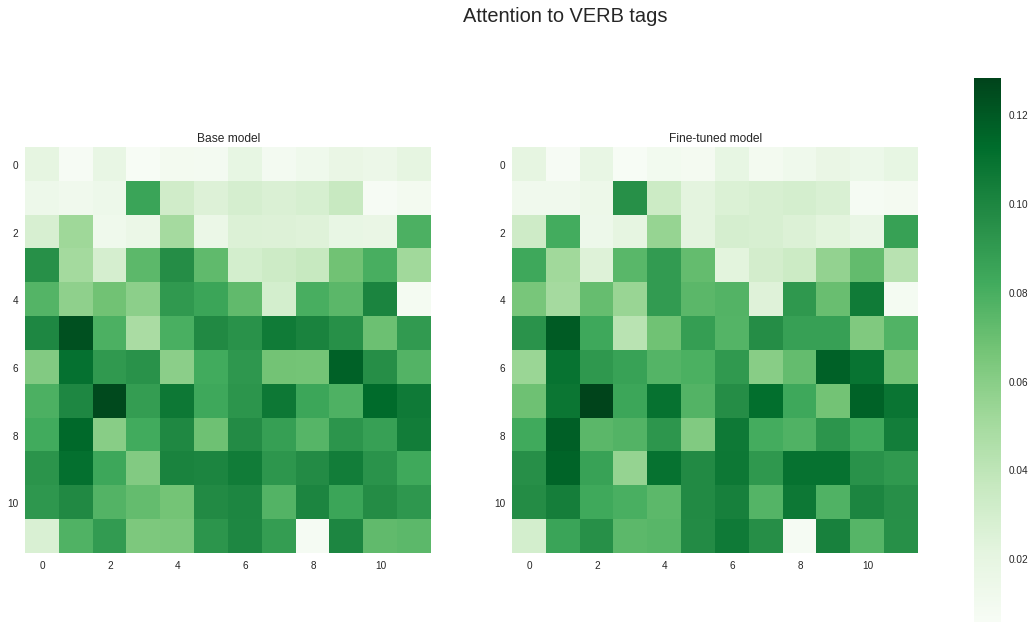

In [37]:
pos = 'VERB'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(text_data):
    weights_finetuned = analyze_target_attention(example, max_len, model_finetuned, feature=pos)
    weights_base = analyze_target_attention(example, max_len, model_base, feature=pos)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to VERB tags')


### 4.3 Target pronouns

100%|██████████| 1000/1000 [06:59<00:00,  2.38it/s]


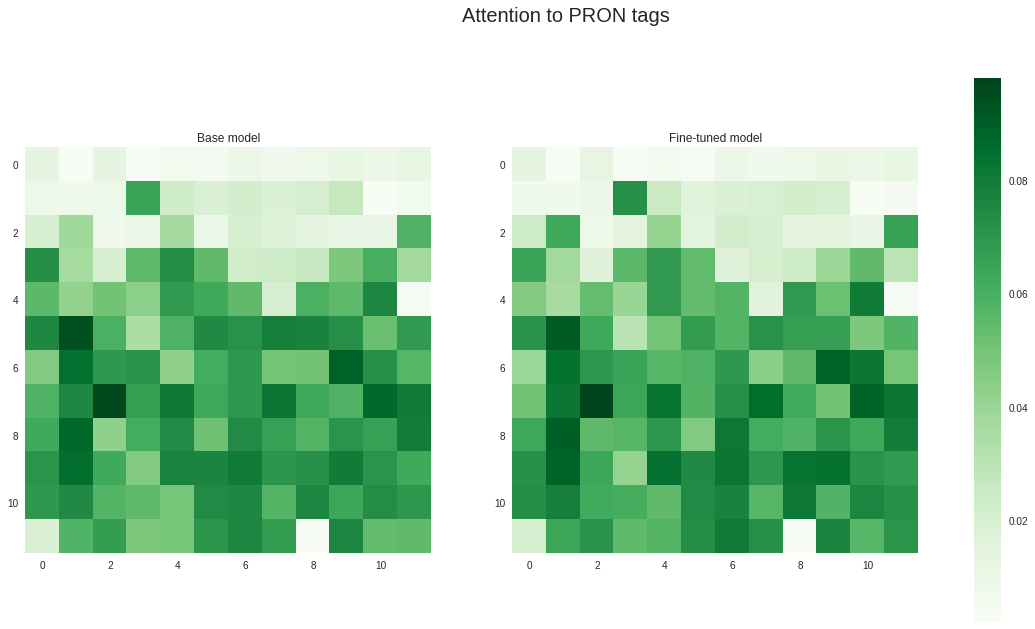

In [38]:
pos = 'PRON'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(text_data):
    weights_finetuned = analyze_target_attention(example, max_len, model_finetuned, feature=pos)
    weights_base = analyze_target_attention(example, max_len, model_base, feature=pos)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to PRON tags')


### 4.4 Target negations

100%|██████████| 1000/1000 [06:42<00:00,  2.49it/s]


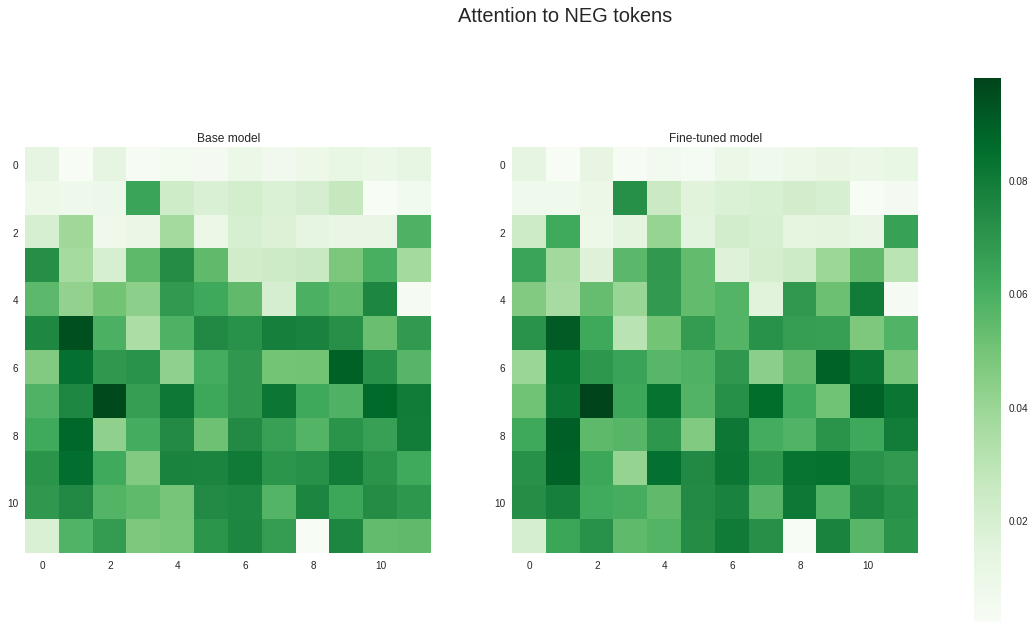

In [39]:
feature = 'NEG'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(text_data):
    weights_finetuned = analyze_target_attention(example, max_len, model_finetuned, feature=pos)
    weights_base = analyze_target_attention(example, max_len, model_base, feature=pos)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to NEG tokens')


### 4.5 Target subjects

100%|██████████| 1000/1000 [06:55<00:00,  2.41it/s]


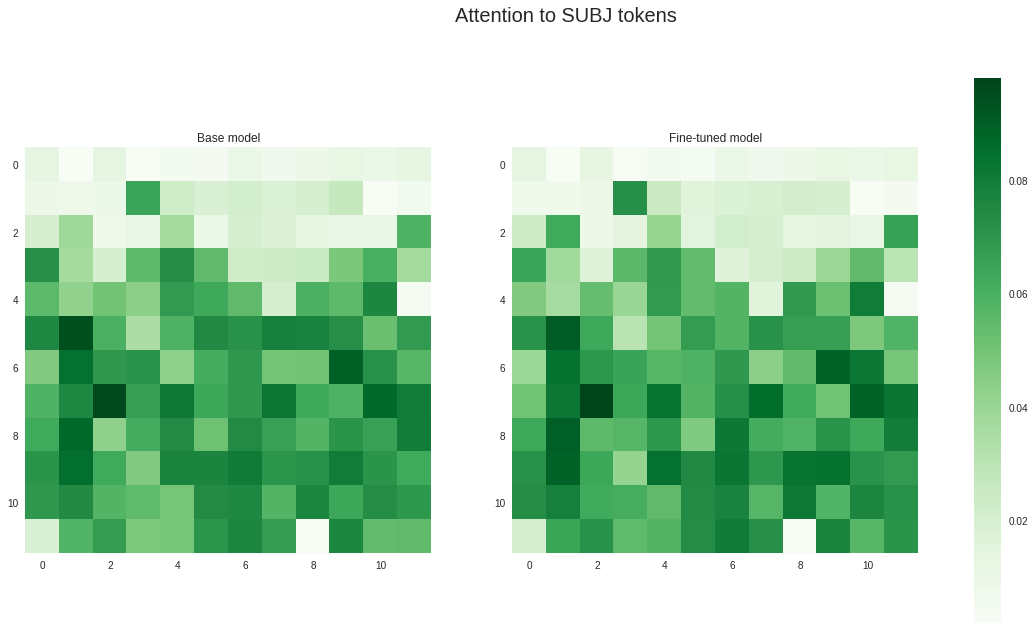

In [40]:
feature = 'SUBJ'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(text_data):
    weights_finetuned = analyze_target_attention(example, max_len, model_finetuned, feature=pos)
    weights_base = analyze_target_attention(example, max_len, model_base, feature=pos)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to SUBJ tokens')

### 4.6 Target objects

100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]


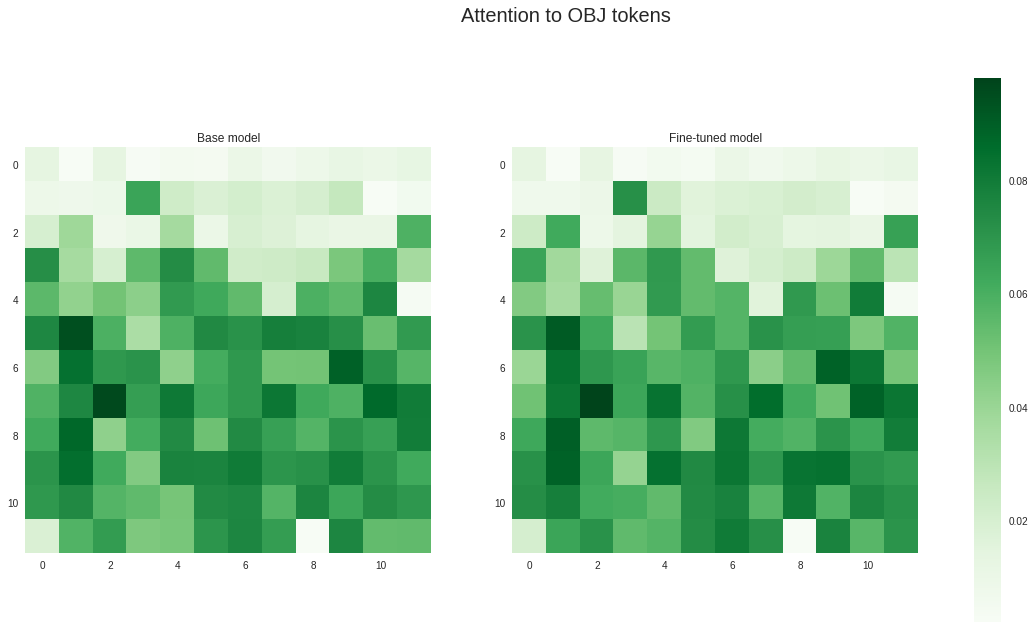

In [41]:
feature = 'OBJ'
all_weights_finetuned = []
all_weights_base = []
for example in tqdm(text_data):
    weights_finetuned = analyze_target_attention(example, max_len, model_finetuned, feature=pos)
    weights_base = analyze_target_attention(example, max_len, model_base, feature=pos)

    all_weights_finetuned.append(weights_finetuned)
    all_weights_base.append(weights_base)

all_weights_finetuned = np.stack(all_weights_finetuned, axis=-1)
all_weights_base = np.stack(all_weights_base, axis=-1)

avg_weights_finetuned = np.mean(all_weights_finetuned, axis=-1)
avg_weights_base = np.mean(all_weights_base, axis=-1)

visualize_before_and_after(avg_weights_base, avg_weights_finetuned, 'Attention to OBJ tokens')